In [3]:
import pandas as pd, numpy as np
import matplotlib, seaborn as sns
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
# load data
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc_series = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)

C:\Users\joche\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


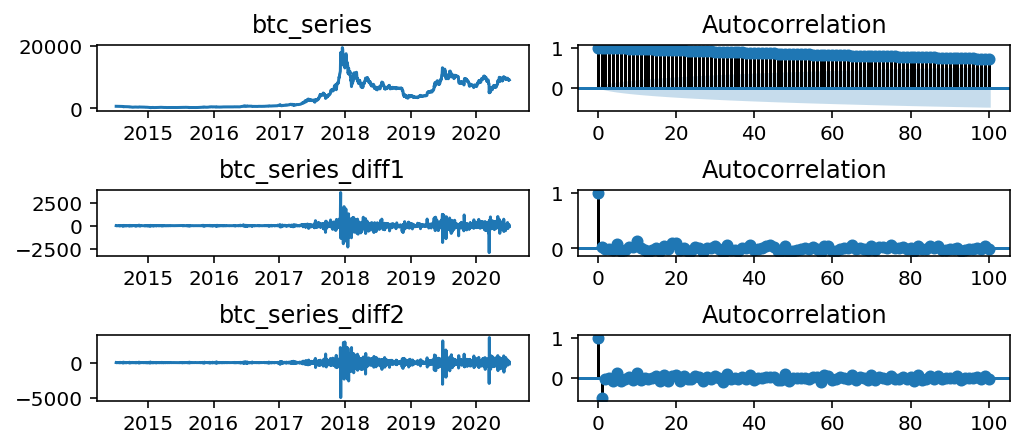

In [4]:
# raw series differencing and acf overview
from statsmodels.graphics.tsaplots import plot_acf
#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_series); axes[0,0].set_title('btc_series')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_series.diff().dropna()); axes[1,0].set_title('btc_series_diff1')
plot_acf((btc_series.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_series.diff().diff().dropna()); axes[2,0].set_title('btc_series_diff2')
plot_acf(btc_series.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [7]:
# log series differencing and acf overview
btc_log = np.log(btc_series)

#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_log); axes[0,0].set_title('btc_series_log')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_log.diff().dropna()); axes[1,0].set_title('btc_series_log_diff1')
plot_acf((btc_log.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_log.diff().diff().dropna()); axes[2,0].set_title('btc_series_log_diff2')
plot_acf(btc_log.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [4]:
from pmdarima.arima.utils import ndiffs
print('ADF_order:\t', ndiffs(btc_series, test='adf'))
print('PP_order:\t', ndiffs(btc_series, test='pp'))
print('KPSS_order:\t', ndiffs(btc_series, test='kpss'))

ADF_order:	 1
PP_order:	 1
KPSS_order:	 1


In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_pacf(btc_series.diff().dropna(), ax=axes[1])

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_acf(btc_series.diff().dropna(), ax=axes[1])

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_pacf(btc_log.diff().dropna(), ax=axes[1])

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_acf(btc_log.diff().dropna(), ax=axes[1])

In [15]:
# manually compare different ARIMA(p,d,q) variants for lowest AIC
from statsmodels.tsa.arima_model import ARIMA
import warnings

def evaluate_arima_variants(p_values, q_values):
    min_aic, opt_order = float('inf'), None
    for p in p_values:
        for q in q_values:
            current_order = (p, 1, q)
            try:
                model = ARIMA(np.log(btc_series), order=current_order)
                model_fit = model.fit(disp=False)
                print('Current try: ARIMA{}'.format(current_order))
                if model_fit.aic < min_aic:
                    min_aic, opt_order = model_fit.aic, current_order
            except:
                continue
    opt_model = ARIMA(np.log(btc_series), order=opt_order)
    opt_fitted = opt_model.fit(disp=False)
    print('ARIMA{}\nAIC:   {}\nBIC:   {}\nHQIC:  {}'.format(opt_order, opt_fitted.aic, opt_fitted.bic, opt_fitted.hqic))
        
p_values = [0, 5, 10]
q_values = [0, 5, 10]
warnings.filterwarnings('ignore')
#evaluate_arima_variants(p_values, q_values)

Current try: ARIMA(0, 1, 0)
Current try: ARIMA(0, 1, 5)
Current try: ARIMA(0, 1, 10)
Current try: ARIMA(5, 1, 0)
Current try: ARIMA(5, 1, 5)
Current try: ARIMA(5, 1, 10)
Current try: ARIMA(10, 1, 0)
Current try: ARIMA(10, 1, 5)
Current try: ARIMA(10, 1, 10)
ARIMA(0, 1, 10)
AIC:   -7962.5181209468765
BIC:   -7894.234688698755
HQIC:  -7937.559129506748


In [6]:
# split data into train and test
train_size = int(len(btc_series) * 0.8)
train, test = btc_series[:train_size], btc_series[train_size:]
print('train:', len(train), '\ntest:', len(test), '\nSUM:', len(train) + len(test), '\nlen btc_series:', len(btc_series))

train: 1750 
test: 438 
SUM: 2188 
len btc_series: 2188


In [10]:
# build ARIMA(0,1,10)
order = (0,1,10)

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(train), order=order)
model_fitted = model.fit(disp=False)
print('ARIMA{}\nAIC:   {}\nBIC:   {}\nHQIC:  {}\n'.format(order, model_fitted.aic, model_fitted.bic, model_fitted.hqic))
print(model_fitted.summary())


ARIMA(0, 1, 10)
AIC:   -6469.983617993512
BIC:   -6404.382024293289
HQIC:  -6445.73242302869

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1749
Model:                ARIMA(0, 1, 10)   Log Likelihood                3246.992
Method:                       css-mle   S.D. of innovations              0.038
Date:                Wed, 08 Jul 2020   AIC                          -6469.984
Time:                        11:35:51   BIC                          -6404.382
Sample:                    07-08-2014   HQIC                         -6445.732
                         - 04-21-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0012      0.001      1.256      0.209      -0.001       0.003
ma.L1.D.Close      0.0161

In [7]:
# Auto fit ARIMA model: model 04
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model_auto = pm.auto_arima(np.log(train), start_p=0, start_q=0, max_p=11, max_q=11,
                      test='adf',
                      m=1,
                      d=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False,
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-6466.554, BIC=-6455.621, Time=0.422 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-6464.874, BIC=-6448.474, Time=0.884 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-6464.887, BIC=-6448.487, Time=0.455 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-6466.744, BIC=-6461.277, Time=0.123 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-6462.881, BIC=-6441.013, Time=0.853 seconds
Total fit time: 2.754 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1750
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3234.372
Date:                Wed, 08 Jul 2020   AIC                          -6466.744
Time:                        13:41:23   BIC                          -6461.277
Sample:                             0   HQIC                 

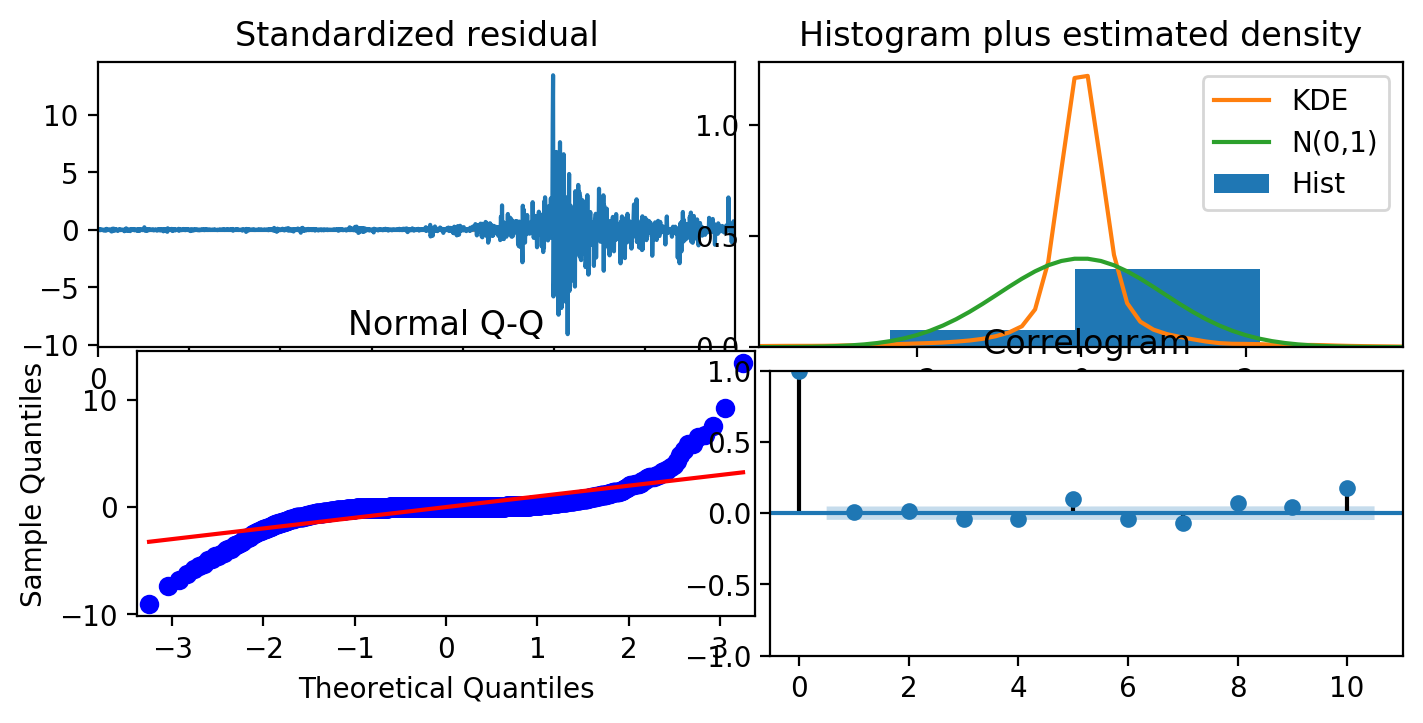

In [27]:
# model 04: review residual errors
model_auto.plot_diagnostics()

In [8]:
# model 04: forecast n_periods
n_periods= len(test)
predictions, conf_int = model_auto.predict(n_periods, return_conf_int=True)
index_pred = np.arange(len(train) + 1, len(btc_series) + 1)

# make series for plotting
predicted_series = np.exp(pd.Series(predictions, index=index_pred))
test_series = pd.Series(test.values, index=index_pred)
lower_band = np.exp(pd.Series(conf_int[:, 0], index=index_pred))
upper_band = np.exp(pd.Series(conf_int[:, 1], index=index_pred))

# plot
plt.plot(train.values, label='training')
plt.plot(test_series, label='actual')
plt.plot(predicted_series, color='darkgreen', label='prediction')
plt.fill_between(lower_band.index, lower_band, upper_band, color='k', alpha=0.15)
plt.legend(loc='upper left')
plt.show()

In [9]:
# model 04: error measures (for n_periods or rolling forecast)
from sklearn.metrics import mean_squared_error as mse

def prediction_accuracy(predictions, actual):
    # MAPE: Mean absolute percentage error
    mape = np.mean(np.abs(predictions - actual) / np.abs(actual))
    # MPE: Mean percentage error
    mpe = np.mean((predictions - actual) / actual)
    # ME: Mean error
    me = np.mean(predictions - actual)
    # MAE: Mean absolute error
    mae = np.mean(np.abs(predictions - actual))
    # RSME: Root mean squared error
    rmse = np.sqrt(mse(predictions, actual))
    # CORR: Correlation between Prediction and Actual
    corr = np.corrcoef(predictions, actual)[0,1]
    
    print('Mean absolute percentage error:\t', mape,\
             '\nMean percentage error:\t\t', mpe,\
             '\nMean error:\t\t\t', me, \
             '\nMean absolute error:\t\t', mae, \
             '\nRoot mean squared error:\t', rmse, \
             '\nCorrelation coefficient:\t', corr, '\n')
    return

prediction_accuracy(predictions, test.values)

Mean absolute percentage error:	 0.9989789758802733 
Mean percentage error:		 -0.9989789758802733 
Mean error:			 -8688.520955393251 
Mean absolute error:		 8688.520955393251 
Root mean squared error:	 8823.431916583264 
Correlation coefficient:	 nan 



C:\Users\joche\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\joche\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [55]:
# model 04: 1 period rolling forecast
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

model_04 = (0,1,0)
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = pm.ARIMA(order = model_04)
    model_fitted = model.fit(y = np.log(history), disp=False)
    yhat = model_fitted.predict(n_periods=1, return_conf_int=False)[0]
    predictions.append(np.exp(yhat))
    history.append(test[i])

print('Predictions: ', predictions)

Predictions:  [5321.042403008394, 5406.031507483045, 5579.331380504715, 5471.642123403774, 5216.831531657887, 5285.780726744923, 5274.697291583851, 5291.573672973098, 5253.712281002346, 5357.273709037632, 5409.333235828255, 5512.09429302932, 5775.578784325241, 5838.570027594681, 5803.04078736332, 5754.0467115981655, 5836.884386727286, 5990.121280754623, 6182.543714774832, 6387.241880544059, 7214.739638888698, 6981.883260582239, 7826.080859796538, 8005.933560554718, 8217.100890957725, 7896.191516590562, 7354.107167004956, 7281.269013172603, 8209.579064799156, 7989.752521697342, 7974.736038068334, 7690.907782618433, 7893.081208420102, 7998.80416469201, 8064.097905656414, 8686.02390356434, 8818.8472131171, 8732.8445962243, 8672.244469197618, 8331.530142408114, 8587.067658324775, 8576.5588206963, 8755.855363077368, 8220.801343202851, 7718.583457311556, 7835.265994417294, 7833.045018723314, 8055.407557957657, 7965.402981799803, 7698.824184038128, 8011.682338974679, 7938.91267197419, 8157.48

In [56]:
# make series for plotting
index_pred = np.arange(len(train) + 1, len(btc_series) + 1)
predicted_series = pd.Series(predictions, index=index_pred)
test_series = pd.Series(test.values, index=index_pred)

# plot
plt.plot(train.values, label='training')
plt.plot(test_series, label='actual')
plt.plot(predicted_series, color='darkgreen', label='prediction')
plt.legend(loc='upper left')
plt.show()

In [57]:
# prediction accuracy for rolling forecast
prediction_accuracy(predictions, test.values)


Mean absolute percentage error:	 0.026814448681740977 
Mean percentage error:		 0.001079850998144096 
Mean error:			 3.0792580324308654 
Mean absolute error:		 230.55321492244818 
Root mean squared error:	 362.9383346725629 
Correlation coefficient:	 0.9723550213007445 

